All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 334:
> We now use boosting to predict `Salary` in the `Hitters` data set.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.tree import DecisionTreeClassifier


sns.set()
%matplotlib inline

In [2]:
hitters = pd.read_csv('https://raw.githubusercontent.com/dsnair/ISLR/master/data/csv/Hitters.csv')
hitters.head(3)

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


Columns:
* `AtBat` &mdash; Number of times at bat in 1986;
* `Hits` &mdash; Number of hits in 1986;
* `HmRun` &mdash; Number of home runs in 1986;
* `Runs` &mdash; Number of runs in 1986;
* `RBI` &mdash; Number of runs batted in in 1986;
* `Walks` &mdash; Number of walks in 1986;
* `Years` &mdash; Number of years in the major leagues;
* `CAtBat` &mdash; Number of times at bat during his career;
* `CHits` &mdash; Number of hits during his career;
* `CHmRun` &mdash; Number of home runs during his career;
* `CRuns` &mdash; Number of runs during his career;
* `CRBI` &mdash; Number of runs batted in during his career;
* `CWalks` &mdash; Number of walks during his career;
* `League` &mdash; A factor with levels A and N indicating player's league at the end of 1986;
* `Division` &mdash; A factor with levels E and W indicating player's division at the end of 1986;
* `PutOuts` &mdash; Number of put outs in 1986;
* `Assists` &mdash; Number of assists in 1986;
* `Errors` &mdash; Number of errors in 1986;
* `Salary` &mdash; 1987 annual salary on opening day in thousands of dollars;
* `NewLeague` &mdash; a factor with levels A and N indicating player's league at the beginning of 1987.

`League`, `Division`, `NewLeague` are categorical.

# (a)

From the textbook, p. 335:
> Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [3]:
hitters = hitters.dropna()
x = pd.get_dummies(hitters.drop(['Unnamed: 0', 'Salary'], axis='columns')
                   , drop_first=True
                  )
y = np.log(hitters.Salary)

# (b)

From the textbook, p. 335:
> Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [4]:
np.random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=200)

# (c)

From the textbook, p. 335:
> Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [5]:
n_estimators = 1000
lr_range = np.linspace(0.0001, 1, 100)

def ada_mse(x_train, y_train, x_test, y_test, n_estimators, lr_range):
  mses = []
  for learning_rate in lr_range:
    model = AdaBoostRegressor(n_estimators=n_estimators
                              , learning_rate=learning_rate
                              )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    mses.append(((y_pred - y_train)**2).mean())
  return mses

mses = ada_mse(x_train, y_train, x_train, y_train, n_estimators, lr_range)

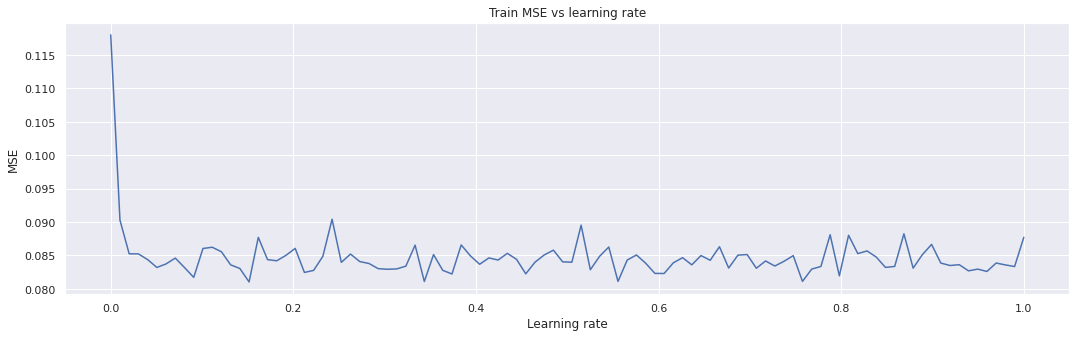

In [6]:
plt.figure(figsize=(18, 5))
sns.lineplot(x=lr_range, y=mses)
plt.title('Train MSE vs learning rate')
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.show()

# (d)

From the textbook, p. 335:
> Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

In [7]:
mses = ada_mse(x_train, y_train, x_test, y_test, n_estimators, lr_range)

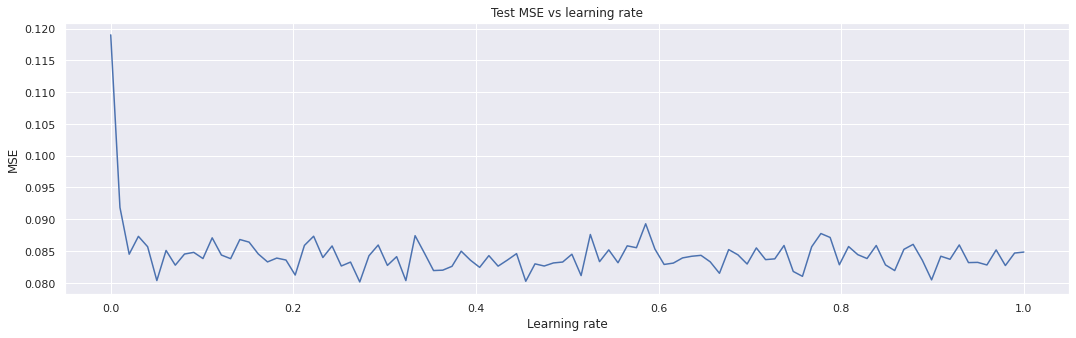

In [8]:
plt.figure(figsize=(18, 5))
sns.lineplot(x=lr_range, y=mses)
plt.title('Test MSE vs learning rate')
plt.xlabel('Learning rate')
plt.ylabel('MSE')
plt.show()

# (e)

From the textbook, p. 335:
> Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [9]:
print(f'Boosting test MSE: {min(mses):.3f}')

model_e1 = LassoCV()
model_e1.fit(x_train, y_train)
y_pred = model_e1.predict(x_test)
print(f'Lasso test MSE: {np.mean((y_pred - y_test)**2):.3f}')

model_e2 = LinearRegression()
model_e2.fit(x_train, y_train)
y_pred = model_e2.predict(x_test)
print(f'Linear regression test MSE: {np.mean((y_pred - y_test)**2):.3f}')

Boosting test MSE: 0.080
Lasso test MSE: 0.509
Linear regression test MSE: 0.453


Boosting gives better result than either Lasso or ordinary least squares.

# (f)

From the textbook, p. 335:
> Which variables appear to be the most important predictors in the boosted model?

In [10]:
model_f = AdaBoostRegressor(n_estimators=n_estimators
                            , learning_rate=0.275
                            )
model_f.fit(x_train, y_train)

feature_importances = np.mean([
    tree.feature_importances_ for tree in model_f.estimators_
], axis=0)
pd.DataFrame({'Importance' : feature_importances}
             , index=x.columns
            ).sort_values('Importance', ascending=False)

,Importance
CAtBat,0.139793
CWalks,0.133311
HmRun,0.098372
CHmRun,0.090940
CHits,0.083204
CRuns,0.082198
RBI,0.070945
CRBI,0.047888
AtBat,0.042667
Walks,0.034256


It seems that there are no dominant predictors. One can notice that six out of eight top predictors are "career" variables &mdash; the total across a player's career up to 1987. 

# (g)

From the textbook, p. 335:
> Now apply bagging to the training set. What is the test set MSE for this approach?

In [11]:
model_g = BaggingRegressor(n_estimators=n_estimators)
model_g.fit(x_train, y_train)
y_pred = model_g.predict(x_test)
print(f'Bagging test MSE: {np.mean((y_pred - y_test)**2):.3f}')

Bagging test MSE: 0.250
